**Assignment 1**

**Exercise 1.1**

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
%matplotlib inline

a) Loading the CIFAR10 dataset in 'trainset'

In [3]:
# Define a transform to convert PIL images to tensors.
transform = transforms.Compose([transforms.ToTensor()])

# Load the training set of CIFAR10.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

b) Print the number of samples and the number of classes.

In [5]:
print("Number of training samples:", len(trainset))
print("Number of classes:", len(trainset.classes))

Number of training samples: 50000
Number of classes: 10


c) Get an example image and print its shape.

In [6]:
image, label = trainset[1234]
print("Shape of an image:", image.shape)

Shape of an image: torch.Size([3, 32, 32])


**Exercise 1.2**

a) Print the number of samples per category.

In [7]:
from collections import Counter
# Extract labels from the dataset.
labels = [label for (_, label) in trainset]

# Count samples for each category using Counter.
label_counts = Counter(labels)

print("Number of samples per category:")
for label_idx, count in label_counts.items():
    print(f"{trainset.classes[label_idx]}: {count}")

Number of samples per category:
frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000


b) Plot the number of samples per category using a bar plot.

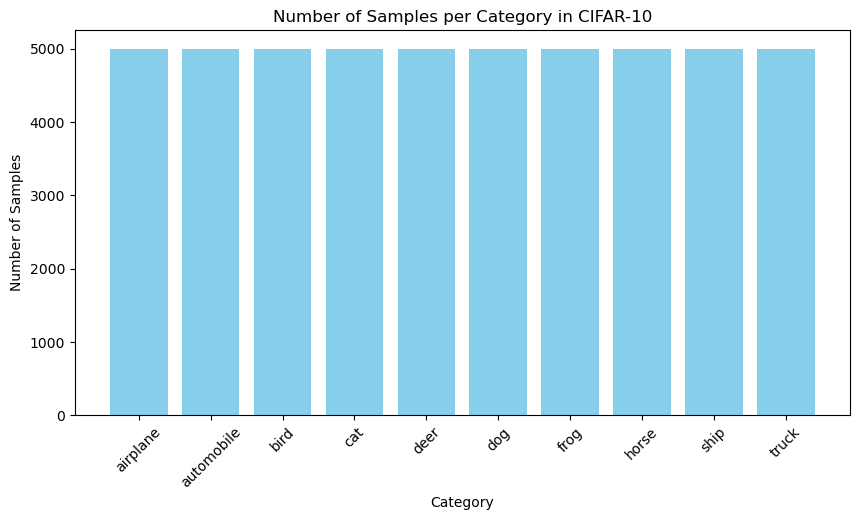

In [8]:
# Prepare data for plotting.
categories = trainset.classes
counts = [label_counts[i] for i in range(len(categories))]

plt.figure(figsize=(10, 5))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Category in CIFAR-10')
plt.xticks(rotation=45)
plt.show()

The CIFAR-10 dataset is balanced; each of the 10 categories has the same number of samples (5,000 images in the training set). There are no majoritarian classes, so you do not have to worry about class imbalance affecting the analysis or the training of your models

**Exercise 1.3**

Create a figure with n x 4 sub-plots. The value of 'n' depends on the number of categories present in the dataset. As the title of each row in your figure, indicate the category it belongs to.

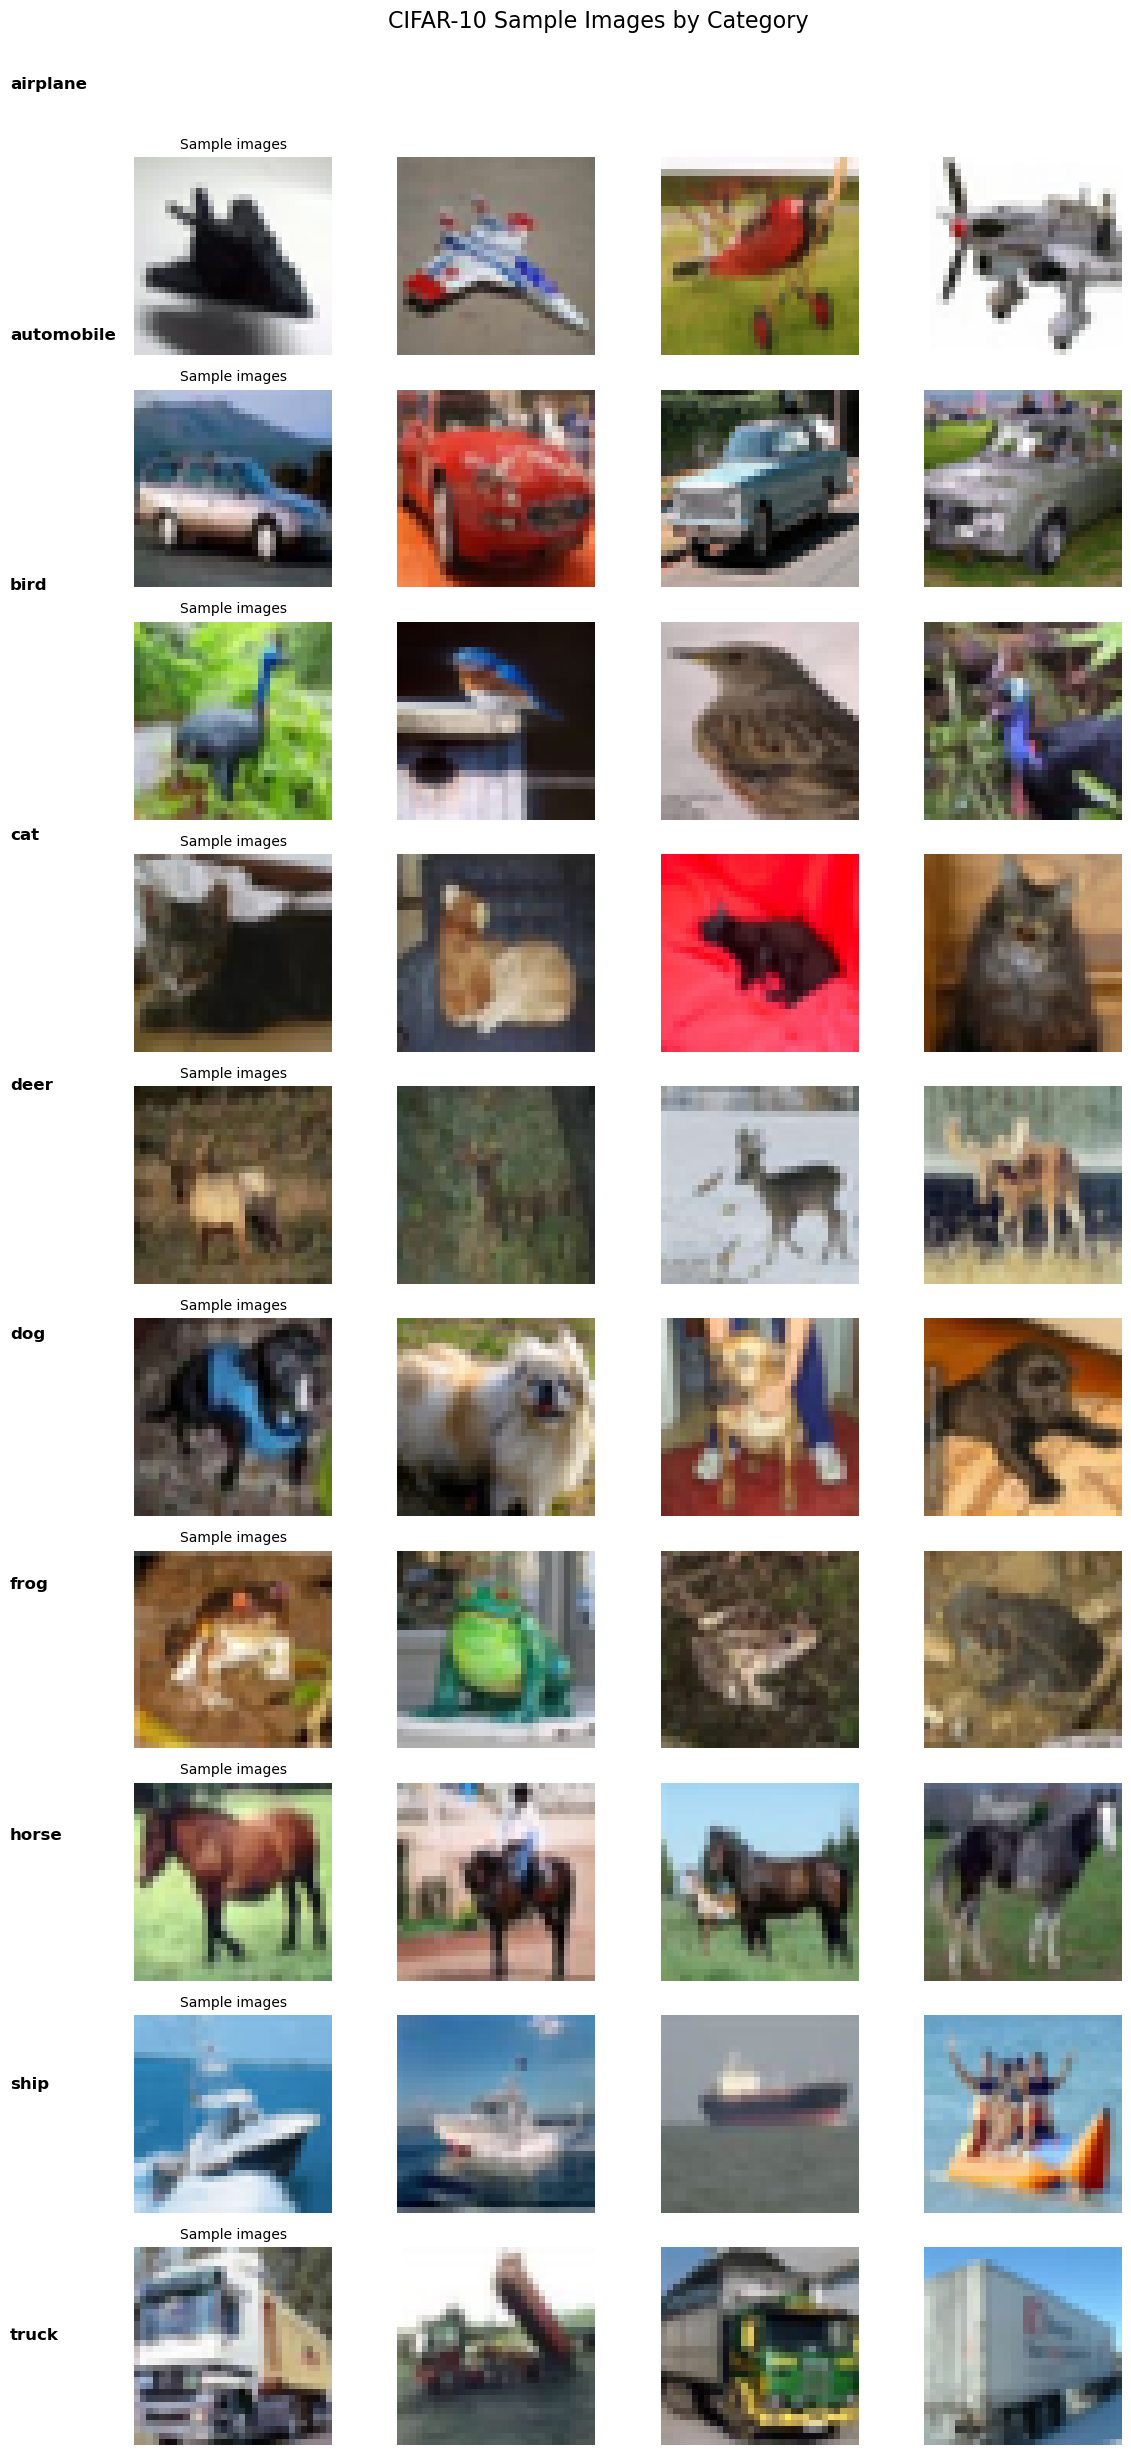

In [10]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Number of classes in the dataset
num_classes = len(trainset.classes)

# Collect 4 images per category
images_by_class = {i: [] for i in range(num_classes)}
for img, label in trainset:
    if len(images_by_class[label]) < 4:
        images_by_class[label].append(img)
    # Stop when we have 4 images for each category
    if all(len(img_list) == 4 for img_list in images_by_class.values()):
        break

# Create a figure with n rows and 4 columns
fig, axes = plt.subplots(num_classes, 4, figsize=(12, 2.5 * num_classes))
plt.subplots_adjust(hspace=0.7, wspace=0.3)  # Increased spacing for better readability

# Add a main title for the figure
fig.suptitle('CIFAR-10 Sample Images by Category', fontsize=16, y=0.98)

# Loop through each category (row) and each sample (column)
for i in range(num_classes):
    category_name = trainset.classes[i]
    
    # Add a row title on the left margin
    fig.text(0.01, 1 - (i + 0.5) / num_classes, category_name, 
             ha='left', va='center', fontsize=12, fontweight='bold')
    
    for j in range(4):
        ax = axes[i, j]
        # Convert tensor (C, H, W) to numpy array (H, W, C) for display
        img_np = images_by_class[i][j].numpy().transpose(1, 2, 0)
        ax.imshow(img_np)
        ax.axis('off')
        
        # Add a subtle subtitle to the first image in each row
        if j == 0:
            ax.set_title(f"Sample images", fontsize=10)

plt.tight_layout(rect=[0.05, 0, 1, 0.95])  # Adjust layout but leave room for row titles
plt.show()

**Exercise 1.4**

Extract RGB values from each image in your dataset as three seperate lists(one per channel). Each list should have 8 values. To do so, you can compute the histogram of each channel with 8 bins. Then you have to concatenate the values of all the three channels together resulting in a feature vector of size 24. This feature vector is the descriptor of an image in your dataset. You will have to do this for all the images present in your dataset in order to get the overall RGB descriptor which will be of size (n,24). Here 'n' depends on the number of samples present in the dataset.

In [11]:
# Initialize a list to store the feature vectors (descriptors) for each image.
descriptors = []

# Iterate over all images in the dataset.
for img, _ in trainset:
    # 'img' is a tensor of shape (3, H, W) with values in [0, 1].
    img_np = img.numpy()  # Convert to NumPy array.
    feature_vector = []
    
    # Loop over each channel: 0: Red, 1: Green, 2: Blue.
    for channel in img_np:
        # Compute the histogram with 8 bins for the current channel.
        hist, _ = np.histogram(channel, bins=8, range=(0, 1))
        # Append the histogram counts to the feature vector.
        feature_vector.extend(hist.tolist())
    
    # The resulting feature_vector has 24 values (8 per channel).
    descriptors.append(feature_vector)

# Convert the list of descriptors into a NumPy array of shape (n, 24).
descriptors = np.array(descriptors)
print("Shape of overall RGB descriptor:", descriptors.shape)

Shape of overall RGB descriptor: (50000, 24)


**Exercise 1.5**

In [13]:
import pandas as pd
# Compute descriptors and collect labels.
# Each descriptor is a 24-dimensional vector obtained by computing 8-bin histograms for each channel.
descriptors = []
labels = []
for img, label in trainset:
    img_np = img.numpy()  # shape: (3, H, W)
    feature_vector = []
    for channel in img_np:
        # Compute an 8-bin histogram for the current channel over the range [0, 1].
        hist, _ = np.histogram(channel, bins=8, range=(0, 1))
        feature_vector.extend(hist.tolist())
    descriptors.append(feature_vector)
    labels.append(label)

descriptors = np.array(descriptors)  # overall descriptor array of shape (n, 24)
labels = np.array(labels)

# Compute the mean descriptor for each class.
# CIFAR-10 has 10 classes.
class_names = trainset.classes  # List of class names.
mean_descriptors = {}
for i, class_name in enumerate(class_names):
    # Select all descriptors corresponding to class i.
    class_descriptors = descriptors[labels == i]
    # Compute the mean descriptor (a vector of length 24) for this class.
    mean_descriptor = np.mean(class_descriptors, axis=0)
    mean_descriptors[class_name] = mean_descriptor

# Create a pandas DataFrame from the mean descriptors.
# Rows correspond to classes and columns correspond to the 24 feature values.
df = pd.DataFrame(mean_descriptors).T
df.columns = [f'bin_{i+1}' for i in range(df.shape[1])]

# Compute the inter-class correlation.
# Since df has classes as rows, we compute the correlation among rows by transposing it.
inter_class_corr = df.T.corr()

print("Inter-class correlation matrix:")
print(inter_class_corr)

Inter-class correlation matrix:
            airplane  automobile      bird       cat      deer       dog  \
airplane    1.000000    0.052321  0.470928  0.139518  0.322096  0.249280   
automobile  0.052321    1.000000  0.806705  0.916883  0.881101  0.863930   
bird        0.470928    0.806705  1.000000  0.916491  0.979866  0.948224   
cat         0.139518    0.916883  0.916491  1.000000  0.954946  0.984555   
deer        0.322096    0.881101  0.979866  0.954946  1.000000  0.962833   
dog         0.249280    0.863930  0.948224  0.984555  0.962833  1.000000   
frog        0.123002    0.931807  0.907693  0.981524  0.959474  0.952901   
horse       0.315648    0.866904  0.968539  0.962153  0.984896  0.968334   
ship        0.887582    0.355914  0.674754  0.417146  0.564242  0.525305   
truck       0.337923    0.890496  0.835521  0.837122  0.876925  0.806994   

                frog     horse      ship     truck  
airplane    0.123002  0.315648  0.887582  0.337923  
automobile  0.931807  0.8

c) Compute the Silhouette score

In [14]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(descriptors, labels, metric='euclidean')
print("Silhouette Score for the extracted descriptors:", sil_score)


Silhouette Score for the extracted descriptors: -0.08492854865203082


Reflection

1. Does Intra-class correlation score/coefficient help you assess the degree of similarity among the samples of a category?

Yes, the intra-class correlation score is a useful measure for assessing how similar the samples within a single category are. A higher intra-class correlation indicates that the samples share common characteristics and are clustered tightly together, which means the feature descriptor is capturing consistent traits of that category. Conversely, a lower intra-class correlation would suggest that the samples vary significantly from one another, potentially indicating that the features are not robust or discriminative enough for that category.

What can you deduce from the Inter-class correlation and Silhouette score?

The inter-class correlation reveals how similar the mean descriptors of different categories are. If the inter-class correlation is high, it suggests that the classes share similar feature characteristics, which could lead to overlapping clusters and difficulties in distinguishing between them. On the other hand, a low inter-class correlation implies that the classes are well separated in the feature space. The silhouette score complements this by evaluating the overall compactness and separation of the clusters. A high silhouette score indicates that the samples are well-clustered within their respective categories and are well separated from other categories, while a low or negative silhouette score would point to overlapping clusters. Together, these metrics provide insights into both the consistency within classes and the distinctiveness between classes, which are critical for effective classification and analysis.

**Exercise 1.6**

a) Rely on the first 2 principal components to plot the samples of your dataset. Use one color per class

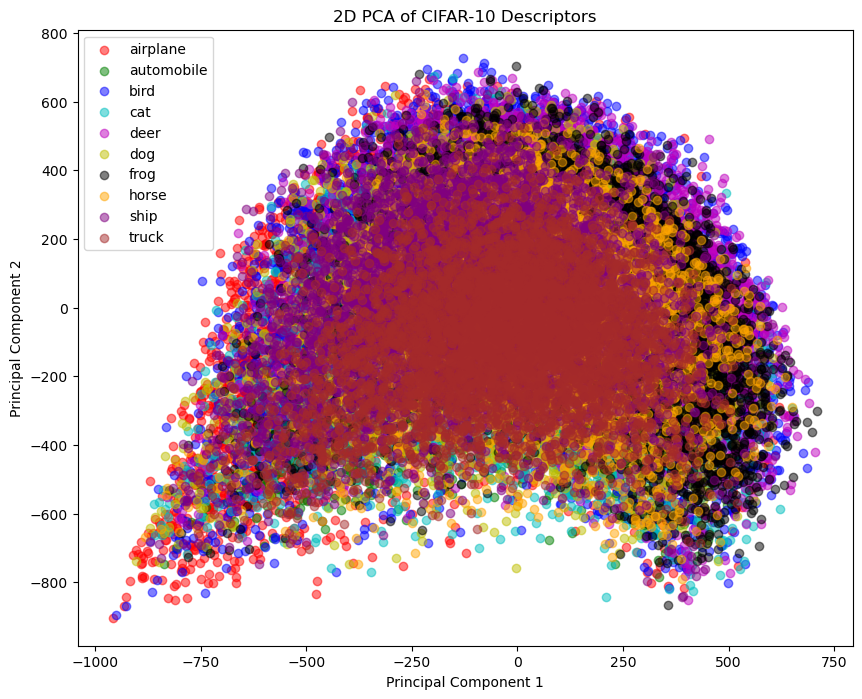

In [16]:
from sklearn.decomposition import PCA
# Apply PCA to reduce to 2 dimensions.
pca_2d = PCA(n_components=2)
descriptors_2d = pca_2d.fit_transform(descriptors)

# Define colors for 10 classes.
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(trainset.classes):
    idx = (labels == i)
    plt.scatter(descriptors_2d[idx, 0], descriptors_2d[idx, 1],
                color=colors[i], label=class_name, alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA of CIFAR-10 Descriptors")
plt.legend()
plt.show()

b) Rely on the first 3 principal components to create a 3D plot. Use one color per class

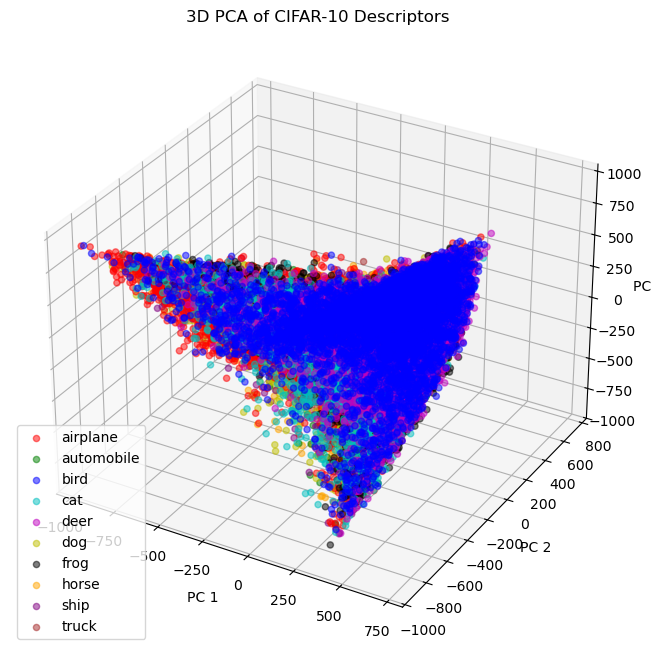

In [17]:
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

# Apply PCA to reduce to 3 dimensions.
pca_3d = PCA(n_components=3)
descriptors_3d = pca_3d.fit_transform(descriptors)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i, class_name in enumerate(trainset.classes):
    idx = (labels == i)
    ax.scatter(descriptors_3d[idx, 0], descriptors_3d[idx, 1], descriptors_3d[idx, 2],
               color=colors[i], label=class_name, alpha=0.5)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title("3D PCA of CIFAR-10 Descriptors")
ax.legend()
plt.show()


**Exercise 1.7 – Reflection**

a) Will you obtain the same visualisation in the feature space for different extracted features?

No, different feature extraction methods capture different aspects of the data. For instance, using simple RGB histograms versus more advanced features (like SIFT, HOG, or deep features) will result in different distributions in the feature space. As a consequence, the PCA visualizations will likely differ based on the extracted features.

b) Are the classes distinguishable on the feature space when relying on PCA over RGB?

Using PCA over basic RGB histograms often does not yield a clearly separable clustering of classes. The RGB descriptors may not capture the higher-level semantics of the images, so some classes might overlap, resulting in less distinguishable clusters.

c) What other visualisation could you include to better describe your data?

Other visualization techniques such as t-SNE or UMAP can provide non-linear dimensionality reduction that often reveals better cluster separation. Additionally, pair plots or dendrograms from hierarchical clustering could help visualize the relationships between samples and classes more effectively.

This completes the solution for the PCA visualization tasks and the reflection questions for your assignment.